<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Building-&amp;-training-the-model-using-COCO-Singles" data-toc-modified-id="Building-&amp;-training-the-model-using-COCO-Singles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Building &amp; training the model using COCO Singles</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Train-w/-cnn_learner" data-toc-modified-id="Train-w/-cnn_learner-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train w/ <code>cnn_learner</code></a></span></li><li><span><a href="#Train-w/-custom_module" data-toc-modified-id="Train-w/-custom_module-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train w/ <code>custom_module</code></a></span></li><li><span><a href="#Messing-around-with-create_body-and-create_head" data-toc-modified-id="Messing-around-with-create_body-and-create_head-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Messing around with <code>create_body</code> and <code>create_head</code></a></span></li></ul></li></ul></div>

# Building & training the model using COCO Singles

## Data

In [ ]:
from fastai.vision.all import *


### Params ###
im_size      = 224
batch_size   = 64
path         = Path('/home/rory/data/coco2017')
train_json   = 'annotations/instances_train2017.json'
valid_json   = 'annotations/instances_val2017.json'
train_im_dir = 'train2017'
valid_im_dir = 'val2017'


### Get files and annos ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]


### Get largest anno ###
def transpose(anno): return list(zip(*anno)) # tensor.t()
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = L(sort_annos(i) for i in annos)
largest_anno = L(i[0] for i in sorted_annos)
largest_bbox = L(i[0] for i in largest_anno)
largest_lbl  = L(i[1] for i in largest_anno)
# get_xyz helpers (used in following sections)
files2lbl  = {f:l for f,l in zip(files,largest_lbl)}
files2bbox = {f:b for f,b in zip(files,largest_bbox)}
def get_lbl(f):  return files2lbl[f]
def get_bbox(f): return files2bbox[f]


### Get singles ###
# identify singles
lbls_per_im = L(len(l) for l in lbls)
tuples = L(zip(files, largest_lbl, largest_bbox))
singles = tuples[lbls_per_im.map(lambda n:n==1)]
singles_tp = transpose(singles)
# identify lbls with at least 500 singles
lbl2paths = {l:[p for p in singles_tp[0] if get_lbl(p) == l] 
             for l in set(singles_tp[1])}
lbl_subset=[]
for lbl in lbl2paths:
    l = len(lbl2paths[lbl])
    if l > 500: lbl_subset += [lbl]
# create subset of ims in lbl_subset
subset = L(s for s in singles if s[1] in lbl_subset)
files_subset = L(i[0] for i in subset)


### Datasets & DataLoaders ###
# dss
dss_tfms = [[PILImage.create], [get_bbox, TensorBBox.create]]
splits = RandomSplitter(.15)(files_subset)
dss = Datasets(files_subset, tfms=dss_tfms, splits=splits)
# dls
cpu_tfms = [PointScaler(), Resize(im_size, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize()]
dls = dss.dataloaders(bs=64, after_item=cpu_tfms, after_batch=gpu_tfms)

In [ ]:
b = nedls.valid.cpu()

In [ ]:
lbl_subset

['airplane',
 'bear',
 'toilet',
 'clock',
 'bird',
 'train',
 'giraffe',
 'stop sign']

## Train w/ `cnn_learner`

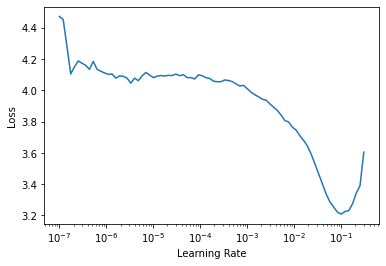

In [ ]:
### Model & Train ###
learn = cnn_learner(dls, resnet34, loss_func=MSELossFlat())
lr_min, _ = learn.lr_find() # lr_min = 1e-2

In [ ]:
learn.fit_one_cycle(1, lr=1e-2) # valid_loss of .0786 after 9 epochs
# learn.export('_20201002_coco_tensorbox_learner_20201005.pkl')

epoch,train_loss,valid_loss,time
0,2.438389,0.561669,00:11


In [ ]:
learn.model.

None


In [ ]:
### Model & Train ###
learn = cnn_learner(dls, resnet34, loss_func=MSELossFlat())
lr_min, _ = learn.lr_find() # lr_min = 1e-2
learn.fit_one_cycle(10, lr=1e-2) # valid_loss of .0786 after 9 epochs
# learn.export('_20201002_coco_tensorbox_learner_20201005.pkl')

KeyboardInterrupt: 

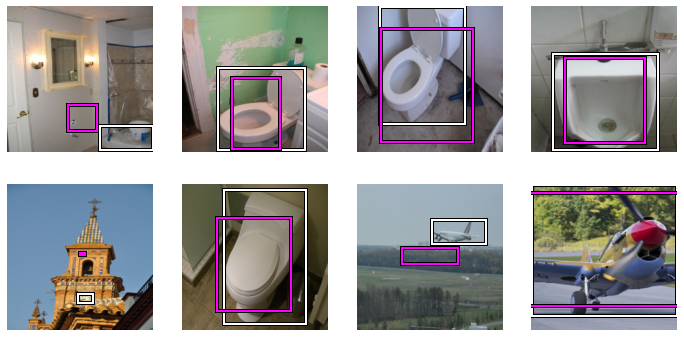

In [ ]:
def show_preds(dss, inf, pipe, n=8, offset=0, nrows=2, ncols=4, sz=224):
    ctxs = get_grid(n, nrows, ncols)
    for i,ctx in enumerate(ctxs):
        im,bb = pipe(dss[i+offset]) # tfms for resizing ims and bbs
        pred = inf.predict(im)
        show_image(im, ctx=ctx)
        ((bb+1)*sz//2).show(ctx=ctx)
        pred[0].show(ctx=ctx, color='magenta')
p = Pipeline([PointScaler(), Resize(im_size, method=ResizeMethod.Squish)])
inf = load_learner('_20201002_coco_tensorbox_learner_20201005.pkl')
show_preds(dss, inf, p)

## Train w/ `custom_module`

In [ ]:
### Custom Model ### (same as cnn_learner)
class custom_module(Module):
    def __init__(self, body, head):
        self.body, self.head = body, head

    def forward(self, x):
        return self.head(self.body(x))

body = create_body(resnet34, pretrained=True)
head = create_head(1024, 4)
mod = custom_module(body, head)

learn2 = Learner(dls, mod, loss_func=MSELossFlat())
learn2.freeze()
learn2.fit_one_cycle(10, lr=1e-2) # valid_loss of .0412 after 9 epochs (2min 24s)

epoch,train_loss,valid_loss,time
0,0.756748,0.334496,00:14
1,0.461485,0.678898,00:14
2,0.281761,0.811503,00:14
3,0.198261,0.127039,00:14
4,0.155411,0.105149,00:14
5,0.118293,0.075935,00:14
6,0.085496,0.064267,00:14
7,0.060963,0.048598,00:14
8,0.046373,0.045734,00:14
9,0.038916,0.042842,00:14


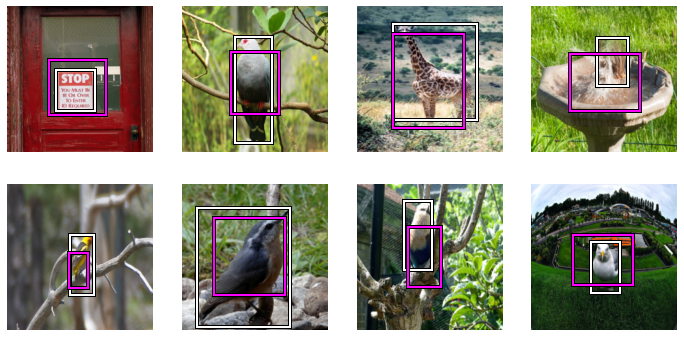

In [ ]:
# learn.export('_20201002_coco_tensorbox_custom_learner_20201005.pkl')
p = Pipeline([PointScaler(), Resize(im_size, method=ResizeMethod.Squish)])
inf = load_learner('_20201002_coco_tensorbox_custom_learner_20201005.pkl')
show_preds(dss, inf, p, offset=20)

## Messing around with `create_body` and `create_head`

In [ ]:
def trivial(x): return x
mod = custom_module(body=create_body(resnet34, pretrained=True),
                    head=trivial)
learn3 = Learner(dls, mod, loss_func=MSELossFlat())
learn3.summary()
# learn3.freeze()
# learn3.fit_one_cycle(10, lr=1e-2) # valid_loss of .0412 after 9 epochs

custom_module (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
______________________________________________

In [ ]:
body = create_body(resnet34, pretrained=True)
linear_head = nn.Sequential(Flatten(), nn.Linear(512*7*7, 4))
mod = custom_module(body, linear_head)
learn3 = Learner(dls, mod, loss_func=MSELossFlat())
learn3.summary()
learn3.freeze()
learn3.fit_one_cycle(10, lr=1e-2) # valid_loss of .0645 after 9 epochs (2min 25s)

epoch,train_loss,valid_loss,time
0,0.331905,0.269707,00:14
1,0.151924,0.121249,00:14
2,0.191973,0.161747,00:14
3,0.197575,0.180287,00:14
4,0.144351,0.139240,00:14
5,0.117063,0.114526,00:14
6,0.092117,0.086659,00:14
7,0.073633,0.073314,00:14
8,0.053121,0.072210,00:14
9,0.040718,0.064549,00:14


In [ ]:
b = dls.one_batch()
learn2._split(b)
(learn2.yb[0]).shape